A single pass of the algorithm requires a parameter m which is between 0 and n (number of points of our set P). Ideally, m=h but h, the number of vertices in the output convex hull, is not known at the start

In [3]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 10)

def draw_hull(points, hull):
    plt.scatter(list(map(lambda x: x[0], points)), list(map(lambda x: x[1], points)), color='c', s=[4] * len(points))
    plt.plot(list(map(lambda x: x[0], hull)), list(map(lambda x: x[1], hull)), 'r')
    plt.show()

In [4]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [1]:
import numpy as np
import random
import math

def random_square_points(n, side = 50):
    points = []
    for _ in range(n):
        points.append((
          random.uniform(0.0, float(side)),
          random.uniform(0.0, float(side))
        ))

    return points

In [6]:
def random_circle_points(n, r = 50):
    points = []
    x_dist = get_truncated_normal(mean=0, sd=(r/1.5), low=-r, upp=r)
    xs = x_dist.rvs(n)
    for x in xs:
        x = float(x)
        y_r = math.sqrt(r ** 2 - x ** 2)
        y = random.uniform(-y_r, y_r)
        points.append((x, y))

    return points

In [7]:
test_point_sets = {
    "square": {},
    "circle": {},
}

for n in range(100, 7001, 100):
    print(n)
    if not test_point_sets["square"].get(n):
        test_point_sets["square"][n] = []
        test_point_sets["circle"][n] = []

    for _ in range(100):
        test_point_sets["square"][n].append(random_square_points(n))
        test_point_sets["circle"][n].append(random_circle_points(n))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000


In [9]:
import functools

TURN_LEFT, TURN_RIGHT, TURN_NONE = (1, -1, 0)

def cmp(a, b):
    return (a > b) - (a < b)

def turn(p, q, r):
    """Returns -1, 0, 1 if p,q,r forms a right, straight, or left turn."""
    return cmp((q[0] - p[0])*(r[1] - p[1]) - (r[0] - p[0])*(q[1] - p[1]), 0)

def keep_left(hull, r):
    while len(hull) > 1 and turn(hull[-2], hull[-1], r) != TURN_LEFT:
        hull.pop()

    if not len(hull) or hull[-1] != r:
        hull.append(r)
    
    return hull

def graham_scan(points):
    points = sorted(points)

    l = functools.reduce(keep_left, points, [])
    u = functools.reduce(keep_left, reversed(points), [])
    return l.extend(u[i] for i in range(1, len(u) - 1)) or l

def rtangent(hull, p):
    l, r = 0, len(hull)
    l_prev = turn(p, hull[0], hull[-1])
    l_next = turn(p, hull[0], hull[(l + 1) % r])
    while l < r:
        c = (l + r) // 2
        c_prev = turn(p, hull[c], hull[(c - 1) % len(hull)])
        c_next = turn(p, hull[c], hull[(c + 1) % len(hull)])
        c_side = turn(p, hull[l], hull[c])
        if c_prev != TURN_RIGHT and c_next != TURN_RIGHT:
            return c
        elif c_side == TURN_LEFT and (l_next == TURN_RIGHT or
                                      l_prev == l_next) or \
                c_side == TURN_RIGHT and c_prev == TURN_RIGHT:
            r = c               # Tangent touches left chain
        else:
            l = c + 1           # Tangent touches right chain
            l_prev = -c_next    # Switch sides
            l_next = turn(p, hull[l], hull[(l + 1) % len(hull)])
    return l

def min_hull_pt_pair(hulls):
    """Returns the hull, point index pair that is minimal."""
    h, p = 0, 0
    for i in range(len(hulls)):
        j = min(range(len(hulls[i])), key=lambda j: hulls[i][j])
        if hulls[i][j] < hulls[h][p]:
            h, p = i, j
    return (h, p)

def next_hull_pt_pair(hulls, pair):
    """
    Returns the (hull, point) index pair of the next point in the convex
    hull.
    """
    p = hulls[pair[0]][pair[1]]
    next = (pair[0], (pair[1] + 1) % len(hulls[pair[0]]))
    for h in (i for i in range(len(hulls)) if i != pair[0]):
        s = rtangent(hulls[h], p)
        q, r = hulls[next[0]][next[1]], hulls[h][s]
        t = turn(p, q, r)
        if t == TURN_RIGHT or t == TURN_NONE:
            next = (h, s)
    return next

def convex_hull(points, shape = 'unknown'):
    n = len(points)
    ms = []
    if shape == "unknown":
        ms = [2]
    elif shape == "square":
        ms = [int(math.log(n, 10) * 7)]
    elif shape == "circle":
        ms = [int(math.sqrt(n))]
    else:
        raise "Unknown shape provided"

    # 2 ^ (2 ^ t)
    t = 1
    while (ms[-1] < len(points)):
        next_m = (1 << (1 << t))
        if next_m > ms[-1]:
            ms.append(next_m)
        t += 1

    total_m = 0

    for m in ms:
        hulls = [graham_scan(points[i:i + m]) for i in range(0, n, m)]
        final_hull = [min_hull_pt_pair(hulls)]

        for _ in range(m):
            total_m += 1
            p = next_hull_pt_pair(hulls, final_hull[-1])

            if p == final_hull[0]:
                res = [hulls[h][i] for h, i in final_hull]
                res.append(res[0])
                return res, total_m

            final_hull.append(p)

7000
Hull:  26
Total m:  47


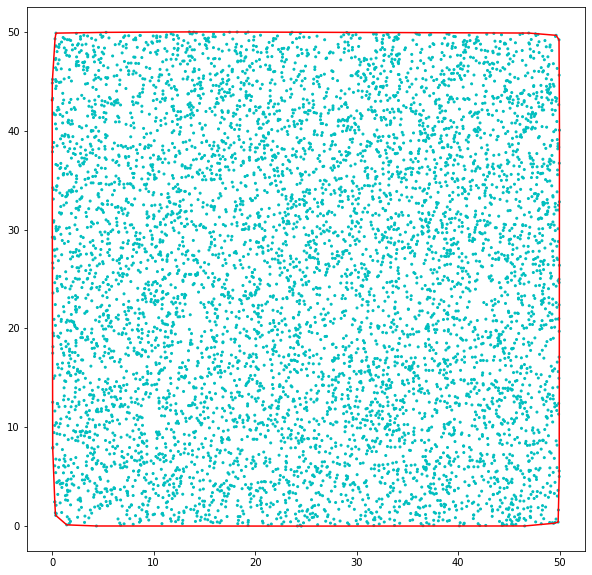

In [13]:
points = test_point_sets["square"][7000][4]
print(len(points))
hull, total_m = convex_hull(points, shape="unknown")
print("Hull: ", len(hull))
print("Total m: ", total_m)

draw_hull(points, hull)

In [384]:
def perform_experiments(test_sets, apply_heuristics = False):
    def experiment(points, shape):
        hull, total_m = convex_hull(points, shape=(shape if apply_heuristics else 'unknown'))
        return { "hull_len": len(hull), "total_m": total_m }

    results = {
        "square": {},
        "circle": {}
    }

    for n in test_sets["square"].keys():
        print(n)

        if not results["square"].get(n):
            results["square"][n] = []
            results["circle"][n] = []

        for points in test_sets["square"][n]:
            results["square"][n].append(experiment(points, shape="square"))

        for points in test_sets["circle"][n]:
            results["circle"][n].append(experiment(points, shape="circle"))
    
    return results
    
    

In [385]:
experiment_results = perform_experiments(test_point_sets)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000


In [386]:
concentration = 0.9

def trend_plot(experiment_results, param = "hull_len"):
    ns = list(experiment_results.keys())
    means = []
    up_bounds = []
    low_bounds = []
    
    for n in ns:
        values = [r[param] for r in experiment_results[n]]
        mean = np.mean(values)
        var = np.var(values)
        dev = np.sqrt(var / (1 - concentration))
        means.append(mean)
        up_bounds.append(mean + dev)
        low_bounds.append(mean - dev)

    plt.xlabel("Number of points")
    plt.ylabel(param)
    plt.plot(ns, means, label="Experimental mean")
    plt.plot(ns, up_bounds, label=f"Chebyshev bounds for p = {concentration}", linestyle="--", color="gray")
    plt.plot(ns, low_bounds, label=None, linestyle="--", color="gray")
    plt.grid()

def histogram(experiment_results, param = "hull_len"):
    values = [p[param] for p in experiment_results]
    mean = np.mean(values)
    var = np.var(values)
    dev = np.sqrt(var / (1 - concentration))
    plt.xlabel("Value")
    plt.ylabel("Number of samples")
    plt.hist(values, bins=len(values) // 2)
    plt.axvline(x=mean, linestyle="--", color="red", label="Mean")
    plt.axvline(x=mean + dev, linestyle="--", color="orange", label=f"Bounds")
    plt.axvline(x=mean - dev, linestyle="--", color="orange")
    plt.grid()
    plt.legend()

# Results for square

### 1. Hull size

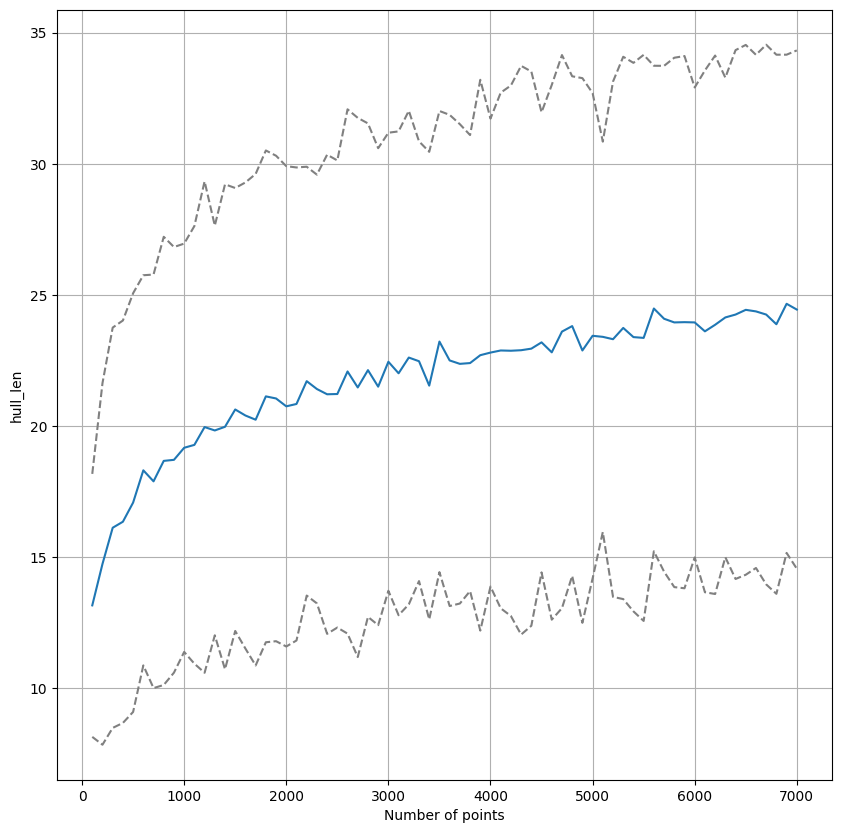

In [387]:
trend_plot(experiment_results["square"], param="hull_len")

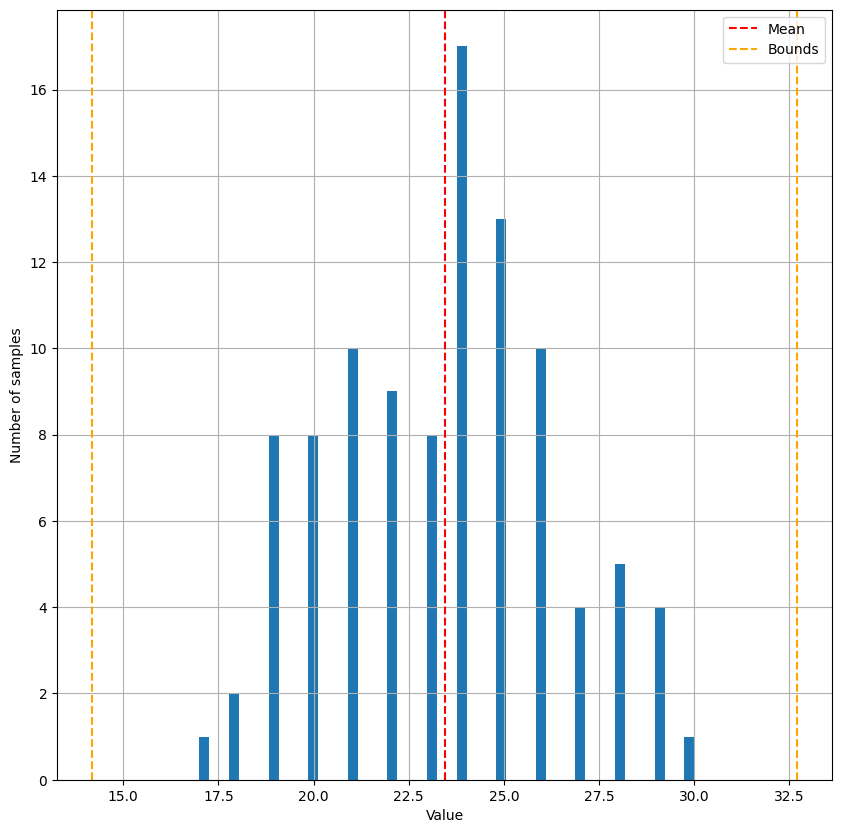

In [388]:
histogram(experiment_results["square"][5000], param="hull_len")

### 2. Total m

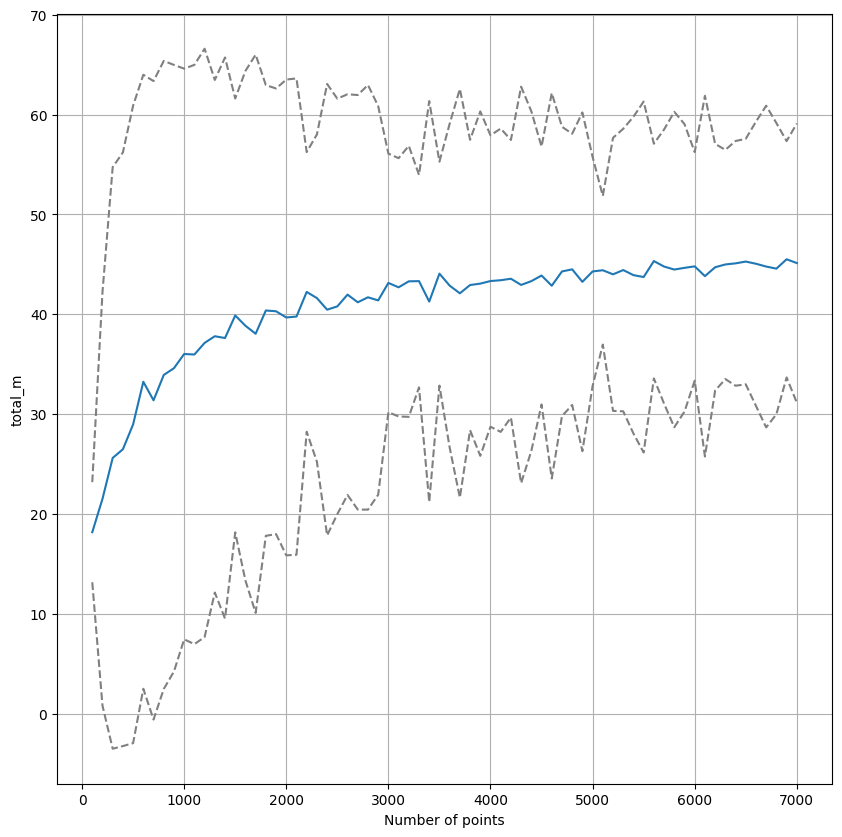

In [389]:
trend_plot(experiment_results["square"], param="total_m")

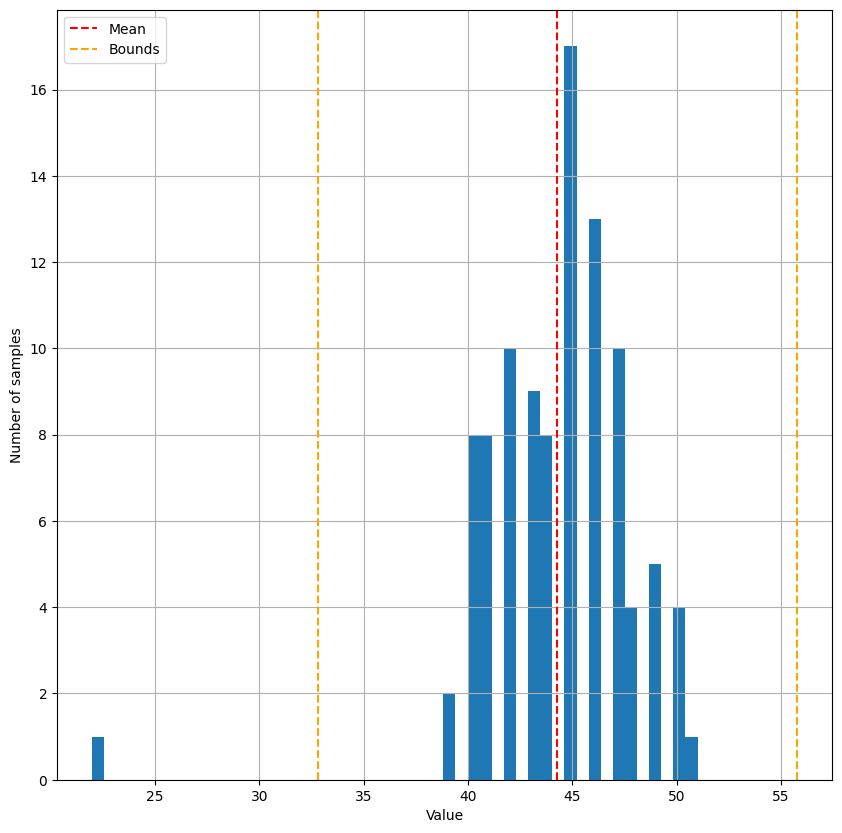

In [390]:
histogram(experiment_results["square"][5000], param="total_m")

# Results for circle

### 1. Hull size

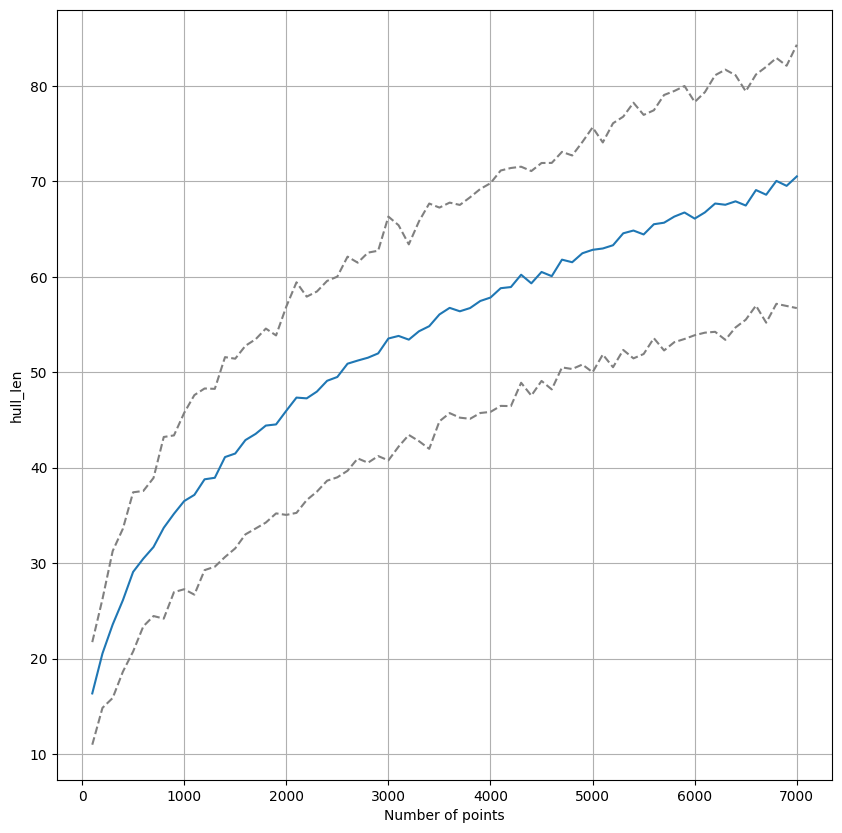

In [391]:
trend_plot(experiment_results["circle"], param="hull_len")

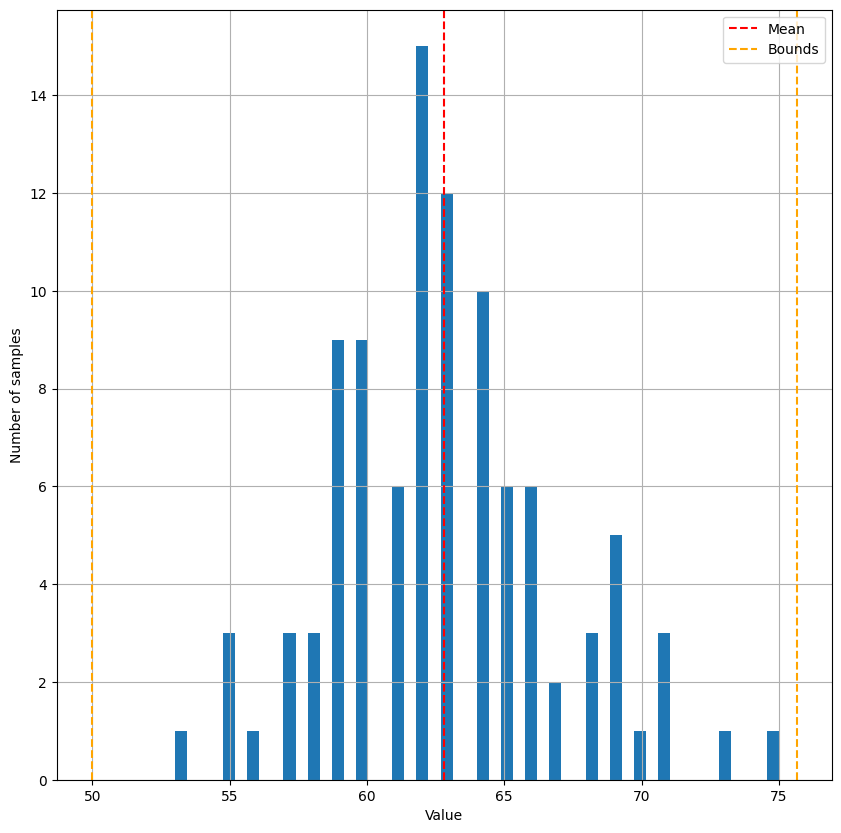

In [392]:
histogram(experiment_results["circle"][5000], param="hull_len")

### 2. Total m

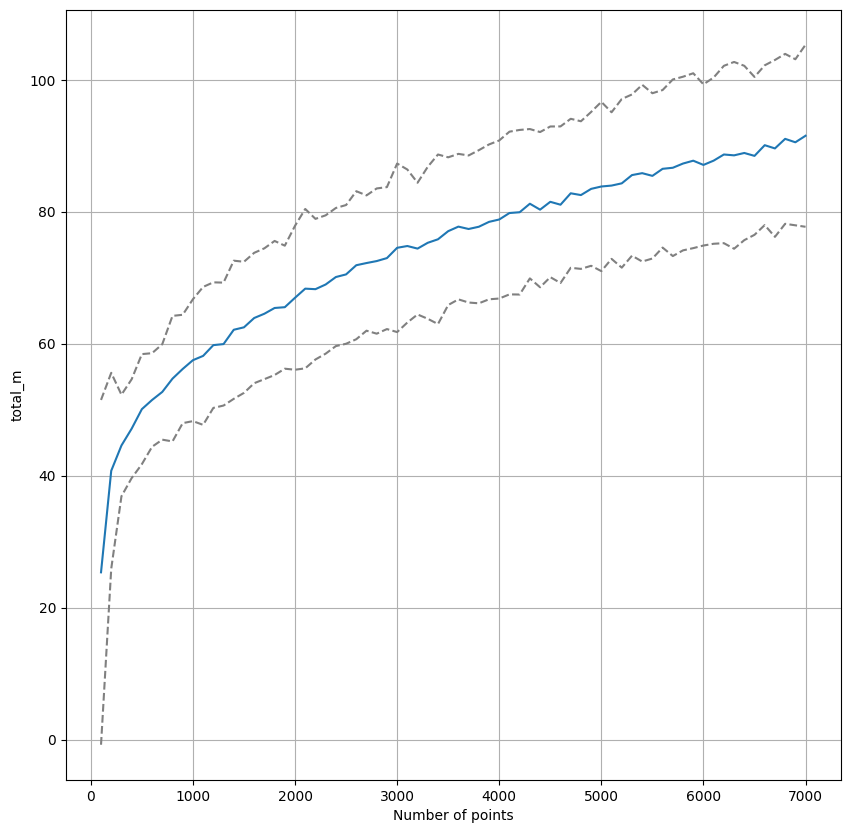

In [393]:
trend_plot(experiment_results["circle"], param="total_m")

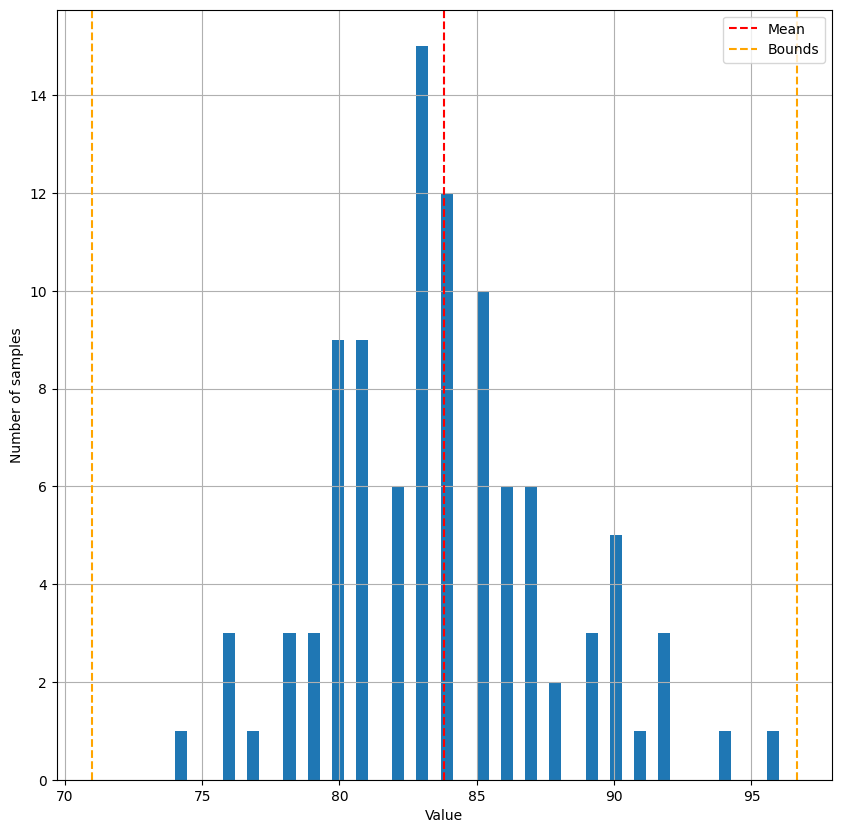

In [394]:
histogram(experiment_results["circle"][5000], param = "total_m")

In [395]:
optimized_experiment_results = perform_experiments(test_point_sets, True) 

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000


In [397]:
def combined_trend_plot(results_1, results_2, param="total_m"):
    ns = list(results_1.keys())
    means_1 = []
    means_2 = []

    for n in ns:
        values_1 = [r[param] for r in results_1[n]]
        values_2 = [r[param] for r in results_2[n]]
        means_1.append(np.mean(values_1))
        means_2.append(np.mean(values_2))

    plt.xlabel("Number of points")
    plt.ylabel(param)
    plt.plot(ns, means_1, label="Mean 1", color="red")
    plt.plot(ns, means_2, label="Mean 2", color="green")
    plt.legend()
    plt.grid()

# Optimized results

## Square

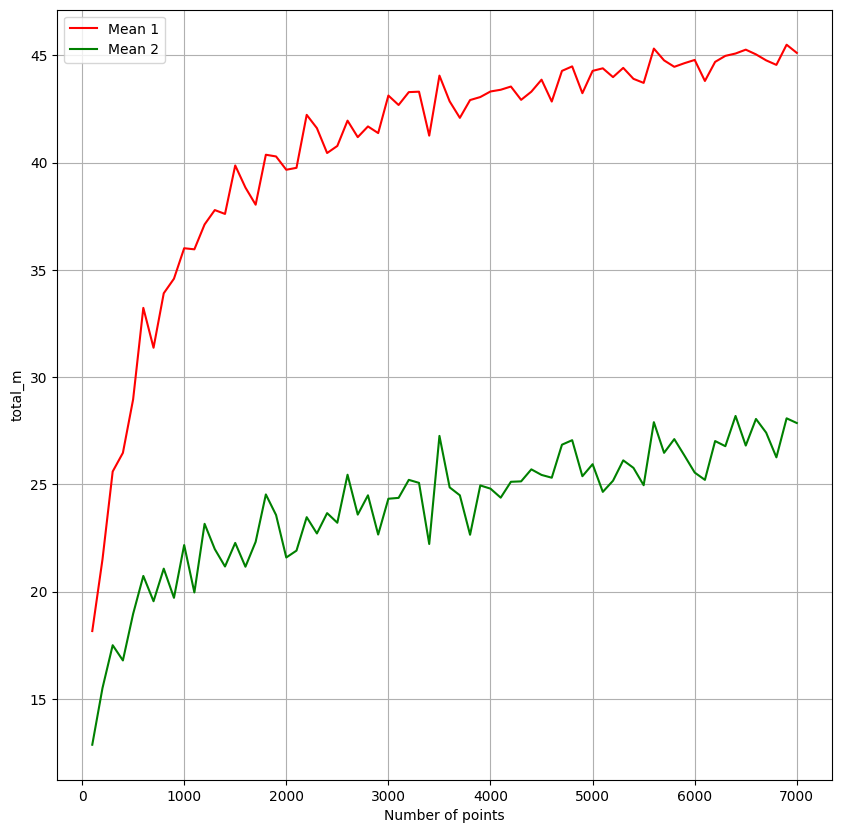

In [398]:
combined_trend_plot(experiment_results["square"], optimized_experiment_results["square"])

## Circle

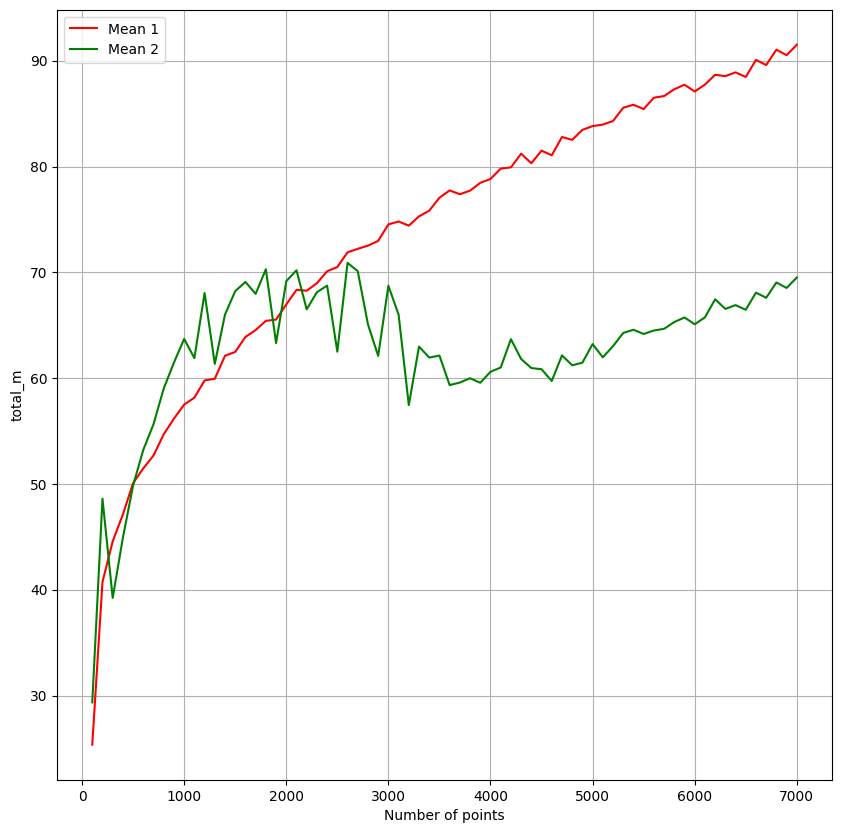

In [399]:
combined_trend_plot(experiment_results["circle"], optimized_experiment_results["circle"])